### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集
- 会自动进行下载

In [2]:
%matplotlib inline

In [3]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"
# 不存在下载数据集
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [4]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

784是mnist数据集每个样本的像素点个数

(50000, 784)


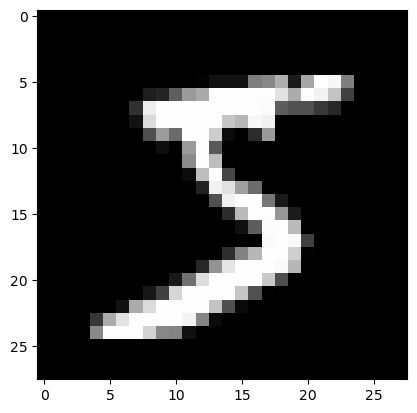

In [5]:
from matplotlib import pyplot
import numpy as np

# reshape((28, 28)) 的目的是将一维数组重新塑造为一个 28x28 的二维数组。在 MNIST 数据集中，每张图像的大小是 28x28 像素，因此这个 reshape 操作有助于将
# 平的一维数组转换为具有图像结构的矩阵形式
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

<img src="./img/4.png" alt="FAO" width="790">

<img src="./img/5.png" alt="FAO" width="790">

注意数据需转换成tensor才能参与后续建模训练


In [6]:
import torch

# 等同如下代码
# x_train = torch.tensor(x_train)
# y_train = torch.tensor(y_train)
# x_valid = torch.tensor(x_valid)
# y_valid = torch.tensor(y_valid)
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [7]:
import torch.nn.functional as F
# 多类别分类任务中的交叉熵损失（Cross Entropy Loss）的函数。在深度学习中，交叉熵损失通常用于衡量模型输出与真实标签之间的差异，特别适用于分类问题
loss_func = F.cross_entropy

def model(xb):
    # .mm矩阵乘法
    return xb.mm(weights) + bias

In [8]:
# 使用的样本数量为 64
bs = 64
# 从训练数据中取出一个大小为 bs 的 mini-batch
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
# 初始化为随机值
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
# 创建一个大小为 10 的偏置向量，并将其初始化为零。与权重类似
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(xb), yb))

tensor(17.0236, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [9]:
from torch import nn

class Mnist_NN(nn.Module):
    # nn.Linear(in_features, out_features) 表示一个全连接层，其中 in_features 是输入特征的数量，而 out_features 是输出特征的数量。
    # self.hidden1、self.hidden2 和 self.out 是三个全连接层，分别连接输入层到第一个隐藏层、第一个隐藏层到第二个隐藏层，以及第二个隐藏层到输出层
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)
        
    # 输入 x 通过两个隐藏层，经过 ReLU 激活函数，并最终通过输出层。每个隐藏层后都应用了 ReLU（Rectified Linear Unit）激活函数，而输出层没有应用激活函数
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x
        

In [10]:
net = Mnist_NN()
print(net)


Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置项

In [11]:
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[ 0.0034, -0.0128, -0.0170,  ...,  0.0306, -0.0351, -0.0171],
        [-0.0254,  0.0339,  0.0154,  ..., -0.0038, -0.0275, -0.0079],
        [-0.0046,  0.0026, -0.0318,  ...,  0.0123,  0.0072, -0.0341],
        ...,
        [-0.0198,  0.0245,  0.0107,  ...,  0.0258,  0.0355,  0.0133],
        [ 0.0220, -0.0186,  0.0028,  ...,  0.0353,  0.0122, -0.0311],
        [-0.0355, -0.0106, -0.0251,  ...,  0.0030, -0.0238, -0.0260]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-0.0323,  0.0086,  0.0338,  0.0338, -0.0062, -0.0254,  0.0267,  0.0149,
        -0.0179,  0.0195,  0.0279, -0.0167, -0.0011, -0.0074, -0.0204,  0.0276,
        -0.0099, -0.0183,  0.0219,  0.0306, -0.0171, -0.0088, -0.0074,  0.0345,
         0.0259,  0.0325,  0.0038,  0.0317, -0.0245,  0.0073, -0.0231, -0.0353,
         0.0241, -0.0129,  0.0024,  0.0024, -0.0176,  0.0043, -0.0318, -0.0101,
        -0.0018,  0.0101, -0.0011, -0.0058, 

### 使用TensorDataset和DataLoader来简化

In [12]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# 创建一个张量数据集，将输入数据 x_train 和对应的标签 y_train 组合在一起
train_ds = TensorDataset(x_train, y_train)
# 建一个数据加载器，用于批量加载训练数据。batch_size=bs 表示每个批次的大小为 bs，而 shuffle=True 表示在每个 epoch 开始时打乱数据。
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
# 表示每个批次的大小为原始 bs 的两倍，通常验证时可以使用更大的批次大小，因为不需要进行梯度更新，只需进行前向传播和损失计算。
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [13]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [19]:
import numpy as np

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        # model.train() 和 model.eval()：这两个方法分别将模型设置为训练模式和评估模式。
        # 在训练模式下，模型会启用 Dropout 等训练时特有的操作。在评估模式下，这些操作会被禁用
        model.train()
        for xb, yb in train_dl:
            # 该函数用于计算并反向传播一个小批次的损失，并根据优化器 opt 更新模型参数
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        # with torch.no_grad() 表示在这个上下文中，不会计算梯度，以加速计算
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        # 计算验证集上的平均损失，其中 losses 是每个小批次的损失，nums 是相应小批次的样本数量。
        # 计算梯度是为了在训练时进行优化，通过梯度下降等方法更新模型参数。然而，在验证集或测试集上进行推理或评估时，我们只关心模型的输出，而不需要梯度信息
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [15]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [16]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

### 三行搞定！

In [20]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：2.278972889328003
当前step:1 验证集损失：2.24297975692749
当前step:2 验证集损失：2.186797924423218
当前step:3 验证集损失：2.0977028667449953
当前step:4 验证集损失：1.9622359336853028
当前step:5 验证集损失：1.766799705505371
当前step:6 验证集损失：1.5189280355453492
当前step:7 验证集损失：1.2736075325012206
当前step:8 验证集损失：1.0779030212402343
当前step:9 验证集损失：0.9326140320777893
当前step:10 验证集损失：0.8228216771125794
当前step:11 验证集损失：0.737878849029541
当前step:12 验证集损失：0.6712585268974304
当前step:13 验证集损失：0.6172151280403138
当前step:14 验证集损失：0.5739468916893006
当前step:15 验证集损失：0.5392406108856201
当前step:16 验证集损失：0.5099261875152588
当前step:17 验证集损失：0.4858154431819916
当前step:18 验证集损失：0.46539434652328493
当前step:19 验证集损失：0.4479294186592102
当前step:20 验证集损失：0.4335480395793915
当前step:21 验证集损失：0.42012251300811765
当前step:22 验证集损失：0.40861220622062683
当前step:23 验证集损失：0.3982287415742874
当前step:24 验证集损失：0.38958998415470125
